In [1]:
from read_data import *
from hyper import *
from alignment import *
from copy import *
from datasets.preprecossing import *
import rpy2
from sklearn.metrics.pairwise import cosine_similarity
from scipy.cluster import hierarchy
from math import sin,cos,pi
import scipy 
from sklearn.metrics import adjusted_rand_score

import seaborn as sns
argk = 5
folder_path = './datas/nolisan/'
# folder_path2 = './datas/ohss/'
subsize = 20
pcanum = 20
tempnum = 1000

In [103]:
datas = sc.read_h5ad("./datas/nature/151507_preprocessed.h5")
datas[datas.obs[datas.obs['layer_guess_reordered']=='Layer1'].index]

View of AnnData object with n_obs × n_vars = 817 × 9948
    obs: 'in_tissue', 'array_row', 'array_col', 'imagerow', 'imagecol', 'sum_umi', 'sum_gene', 'subject', 'position', 'replicate', 'discard', 'cell_count', 'layer_guess', 'layer_guess_reordered', 'layer_guess_reordered_short', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'n_counts'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_counts'
    uns: 'layer_guess_reordered_colors'
    obsm: 'spatial'

In [112]:
# datas = sc.read_h5ad("./datas/nature/151507_preprocessed.h5")
# adata_subset = datas[:tempnum,:]
datas = sc.read_h5ad("./datas/nature/151507_preprocessed.h5")
datas = datas[datas.obs[datas.obs['layer_guess_reordered']!='Layer1'].index]
sc.write('./datas/nature/lessL1.h5',datas)
datas = sc.read_h5ad("./datas/nature/lessL1.h5")
indices = np.random.choice(datas.n_obs, size=subsize, replace=False)


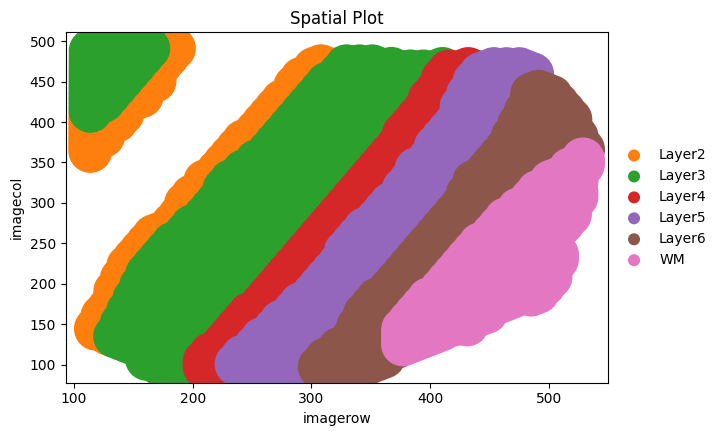

In [113]:
sc.pl.scatter(datas,'imagerow', 'imagecol', color='layer_guess_reordered', title='Spatial Plot',size=4000)

In [114]:
count_sub = datas.to_df()
xy_coords = pd.DataFrame(datas.obsm['spatial'],columns=['imagerow','imagecol'],index= datas.obs.index)
xy_coords.to_csv(folder_path+"xy.csv")
datas.obs.to_csv(folder_path+'meta_data.csv');
count_sub.T.to_csv(folder_path+"gene.csv")

In [115]:
# robjects.r("load(paste0('./datas/pca/DLPFC/LIBD_sample1.RData'))")
from rpy2.robjects.packages import importr
import rpy2.robjects as robjects

Spatialpc  = importr('SpatialPCA')
ggplot2 = importr('ggplot2')
scran = importr('scran')
bluster = importr('bluster')
matrix = importr('Matrix')
robjects.r("xy_coords <- read.csv('{}',row.names='X')".format(folder_path + 'xy.csv'))
robjects.r("xy_coords=as.matrix(xy_coords)")
robjects.r("count_temp <- read.csv('{}',row.names='X')".format(folder_path + 'gene.csv'))
robjects.r('my_matrix <- do.call(cbind, count_temp)')
robjects.r('my_sparse_matrix <- Matrix(my_matrix, sparse = TRUE)')
robjects.r('count_sub <- as(my_sparse_matrix, "dgCMatrix")')
robjects.r('rownames(count_sub) <- rownames(count_temp)')
robjects.r("rownames(xy_coords) = colnames(count_sub)");
robjects.r('LIBD = CreateSpatialPCAObject(counts=count_sub, location=xy_coords, project = "SpatialPCA",gene.type="spatial",sparkversion="spark",numCores_spark=5,gene.number=3000, customGenelist=NULL,min.loctions = 20, min.features=20)')
robjects.r('LIBD = SpatialPCA_buildKernel(LIBD, kerneltype="gaussian", bandwidthtype="SJ",bandwidth.set.by.user=NULL)')
robjects.r('LIBD = SpatialPCA_EstimateLoading(LIBD,fast=FALSE,SpatialPCnum={})'.format(pcanum))
robjects.r('LIBD = SpatialPCA_SpatialPCs(LIBD, fast=FALSE)')
robjects.r('write.csv(as.data.frame(LIBD@SpatialPCs), file = "{}")'.format(folder_path + "pca.csv"))
robjects.globalenv.clear()


## Use SCTransform function in Seurat to normalize data. 


  |======================================================================| 100%


  |======================================================================| 100%


  |======================================================================| 100%







  |                                                                            
  |                                                                      |   0%
  |                                                                            
  |=====                                                                 |   7%
  |                                                                            
  |==========                                                            |  14%
  |                                                                            
  |===============                                                       |  21%
  |                                                                            
  |====================                                                  |  29%
  |                                                                            
  |=========================                                             |  36%
  |                                

## Use spark.test function in SPARK package to select spatially variable genes. 
## ===== SPARK INPUT INFORMATION ==== 
## number of total samples:  3403 
## number of total features:  4416 
## number of adjusted covariates:  0 
# fitting normalized count-based spatial model under the null hypothesis ... 
## testing Gaussian kernel: 1...
## testing Periodic kernel: 1...
## testing Gaussian kernel: 2...
## testing Periodic kernel: 2...
## testing Gaussian kernel: 3...
## testing Periodic kernel: 3...
## testing Gaussian kernel: 4...
## testing Periodic kernel: 4...
## testing Gaussian kernel: 5...
## testing Periodic kernel: 5...
## Identified  1038  spatial genes through spark.test function. 
The  number of significant spatial genes is less than the specified number of spatial genes. 
## Using  1038  significant spatially variable genes. 
## Selected kernel type is:  gaussian  
## The bandwidth is:  0.0385199868116861  
## Calculating kernel matrix
## Finished calculating kernel matrix

In [117]:
adata1 = pd.read_csv(folder_path + 'pca.csv')
adata1 = adata1.set_index(adata1.columns[0])
adata1 = adata1.T
adata1.index = datas.obs.layer_guess_reordered
adata1
# adata1.to_csv(folder_path+'datas.data',header=None);
# adata1.to_csv(folder_path+'datas.csv')

Unnamed: 0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
layer_guess_reordered,,,,,,,,,,,,,,,,,,,,
Layer3,2.976262,1.606790,1.113604,0.656239,1.594282,1.368178,0.479762,-0.053837,0.448436,-0.577251,-0.061239,1.192327,-0.364931,0.044359,-0.336299,0.396390,0.671166,0.134153,0.218525,0.171846
WM,-18.744059,-3.802807,4.109066,-1.949537,1.680510,0.814672,-0.364244,0.796597,-0.207383,-1.155515,1.088094,0.440657,0.932376,-1.521904,0.604432,-2.179714,-1.779375,-0.640714,0.085554,-0.331195
Layer6,0.481683,1.653375,-1.213863,-1.878579,-2.827106,2.696064,5.055828,0.411969,1.181938,-1.648528,1.275187,0.212513,-1.787063,-0.131854,-0.832233,1.604730,-1.499493,0.679212,0.292648,1.562693
Layer6,-2.465957,-0.262562,-1.730742,-2.333626,-2.371467,2.071733,3.889027,0.614419,0.984676,0.225532,1.342076,1.311040,-2.192951,0.571413,0.270414,0.466432,-0.094985,-0.817090,-0.501995,-0.868344
WM,-6.754236,0.171506,0.551474,-0.194842,-0.335564,-0.660689,-0.901966,-0.658803,-0.201478,0.024974,-0.209792,-0.535914,1.513218,-0.477996,3.128996,1.541863,2.473845,-1.054746,-0.101717,-0.037284
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Layer4,-1.212798,2.095025,-0.926399,1.332444,-1.243656,1.563703,-0.728442,-1.220188,-1.966070,0.886386,-0.338756,-1.889547,0.182913,-0.276848,-1.014024,-1.490453,-2.489577,-0.670281,-1.122370,1.035181
Layer3,3.724559,-1.422510,2.427778,-0.072179,0.280565,-0.861196,-0.187155,0.780755,0.030120,-0.003283,-0.545641,-0.296361,-0.042681,0.369093,-0.075509,0.226205,-0.409614,-0.574526,-0.322723,1.357591
Layer6,-2.723589,0.796719,-1.176576,-3.064390,-0.084505,-1.170914,1.456845,-1.565553,1.205817,0.329488,-0.897647,-0.772936,0.238840,0.503666,-0.588534,0.444793,-0.755307,-0.317508,-0.443712,-0.134122


In [118]:
adata1.T.to_csv(folder_path+'annT.csv',index=None)

In [119]:
args=[ i+1 for i in range(100)];
steps = [i+1 for i in range(10)];
anss = [];
ansss = [];
for argk in args:
    for step in steps:
        matrix = importr('Matrix')
        # igraph = importr('igraph')
        robjects.r("library('igraph')")
        robjects.r(" xys <- read.csv('{}')".format(folder_path+'annT.csv'));
        robjects.r("g <- buildSNNGraph(xys,k={})".format(argk))
        robjects.r("walktrap <- walktrap.community(g,steps={})".format(step))
        robjects.r("clusters <- membership(walktrap)")
        robjects.r("write.csv(clusters,file='{}')".format(folder_path+'cluster.csv'))
        robjects.globalenv.clear()
        meta1 = pd.read_csv(folder_path+'cluster.csv')
        meta1 = meta1.set_index(meta1.columns[0])
        meta1['x'].tolist()
        ari = adjusted_rand_score(meta1['x'].tolist(), datas.obs['layer_guess_reordered'].tolist())
        print("ARI score for {},{}: ".format(argk,step), ari)
        # datas.obs['julei']= meta1['x'].tolist()
        # sc.pl.scatter(datas,'imagerow', 'imagecol', color='julei', title='Spatial Plot',size=4000)
        anss.append(ari)

        ansss.append(meta1['x'].tolist())

ARI score for 1,1:  0.006107050687630897
ARI score for 1,2:  0.006107050687630897
ARI score for 1,3:  0.006107050687630897
ARI score for 1,4:  0.006107050687630897
ARI score for 1,5:  0.006107050687630897
ARI score for 1,6:  0.006107050687630897
ARI score for 1,7:  0.006107050687630897
ARI score for 1,8:  0.006107050687630897
ARI score for 1,9:  0.006107050687630897
ARI score for 1,10:  0.006107050687630897
ARI score for 2,1:  0.055515552909418765
ARI score for 2,2:  0.05667660440098198
ARI score for 2,3:  0.06653088625560025
ARI score for 2,4:  0.09461960724757211
ARI score for 2,5:  0.09317819676832041
ARI score for 2,6:  0.08449200930298546
ARI score for 2,7:  0.07951423946004432
ARI score for 2,8:  0.09616084758829445
ARI score for 2,9:  0.08563176937576299
ARI score for 2,10:  0.08958429084911364
ARI score for 3,1:  0.09376119775420773
ARI score for 3,2:  0.12950431368205378
ARI score for 3,3:  0.12381017122877873
ARI score for 3,4:  0.14777943647142303
ARI score for 3,5:  0.15082

In [120]:
indexss

451

In [121]:
np.array(anss).max()

0.546839527940628

In [21]:
julei = []
for i in anss[indexss]:
    julei.append(i)

NameError: name 'anss' is not defined

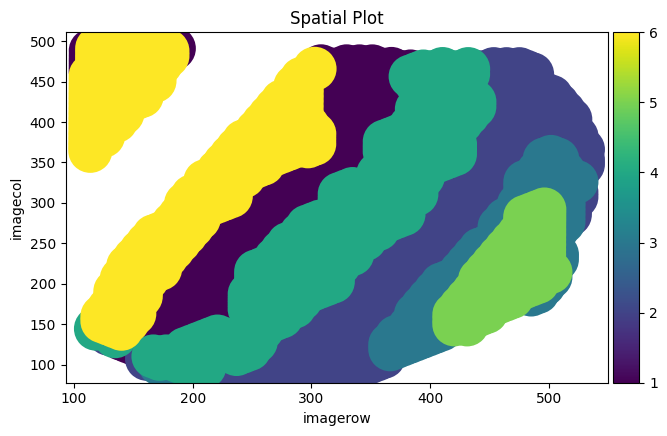

In [122]:
indexss= anss.index(np.array(anss).max())
datas.obs['julei']= ansss[indexss]
sc.pl.scatter(datas,'imagerow', 'imagecol', color='julei', title='Spatial Plot',size=4000)

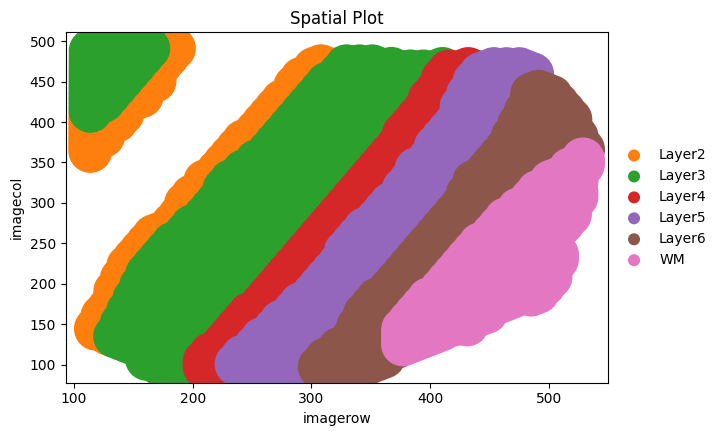

In [123]:
sc.pl.scatter(datas,'imagerow', 'imagecol', color='layer_guess_reordered', title='Spatial Plot',size=4000)

In [124]:
adata1.to_csv(folder_path+"datas.data",header=None);
adata1.to_csv(folder_path+"datas.csv");

./datas/nolisan/datas.data length:3403
Generating all pairs subset


100%|██████████| 1563/1563 [01:11<00:00, 22.01ex/s, loss=0.908450] 


	 Epoch 0 | average train loss: 1.029491
Optimization finished.


100%|██████████| 1563/1563 [01:07<00:00, 23.17ex/s, loss=0.931499] 


	 Epoch 1 | average train loss: 1.017461
Optimization finished.


100%|██████████| 1563/1563 [01:05<00:00, 23.87ex/s, loss=1.041408] 


	 Epoch 2 | average train loss: 1.005165
Optimization finished.


100%|██████████| 1563/1563 [01:06<00:00, 23.41ex/s, loss=0.958517] 


	 Epoch 3 | average train loss: 0.994736
Optimization finished.


100%|██████████| 1563/1563 [01:05<00:00, 23.81ex/s, loss=1.064849] 


	 Epoch 4 | average train loss: 0.986048
Optimization finished.


100%|██████████| 1563/1563 [01:05<00:00, 23.71ex/s, loss=0.938221] 


	 Epoch 5 | average train loss: 0.979185
Optimization finished.


100%|██████████| 1563/1563 [01:05<00:00, 23.90ex/s, loss=1.016437] 


	 Epoch 6 | average train loss: 0.974052
Optimization finished.


100%|██████████| 1563/1563 [01:05<00:00, 23.70ex/s, loss=0.949868] 


	 Epoch 7 | average train loss: 0.969706
Optimization finished.


100%|██████████| 1563/1563 [01:04<00:00, 24.12ex/s, loss=1.030168] 


	 Epoch 8 | average train loss: 0.966349
Optimization finished.


100%|██████████| 1563/1563 [01:06<00:00, 23.66ex/s, loss=1.067773] 


	 Epoch 9 | average train loss: 0.966276
Optimization finished.


/Users/dongjiajie/Desktop/alignment/fyp/hyperalignment/stst/utils/visualization.py:23: RuntimeWarning:

invalid value encountered in divide



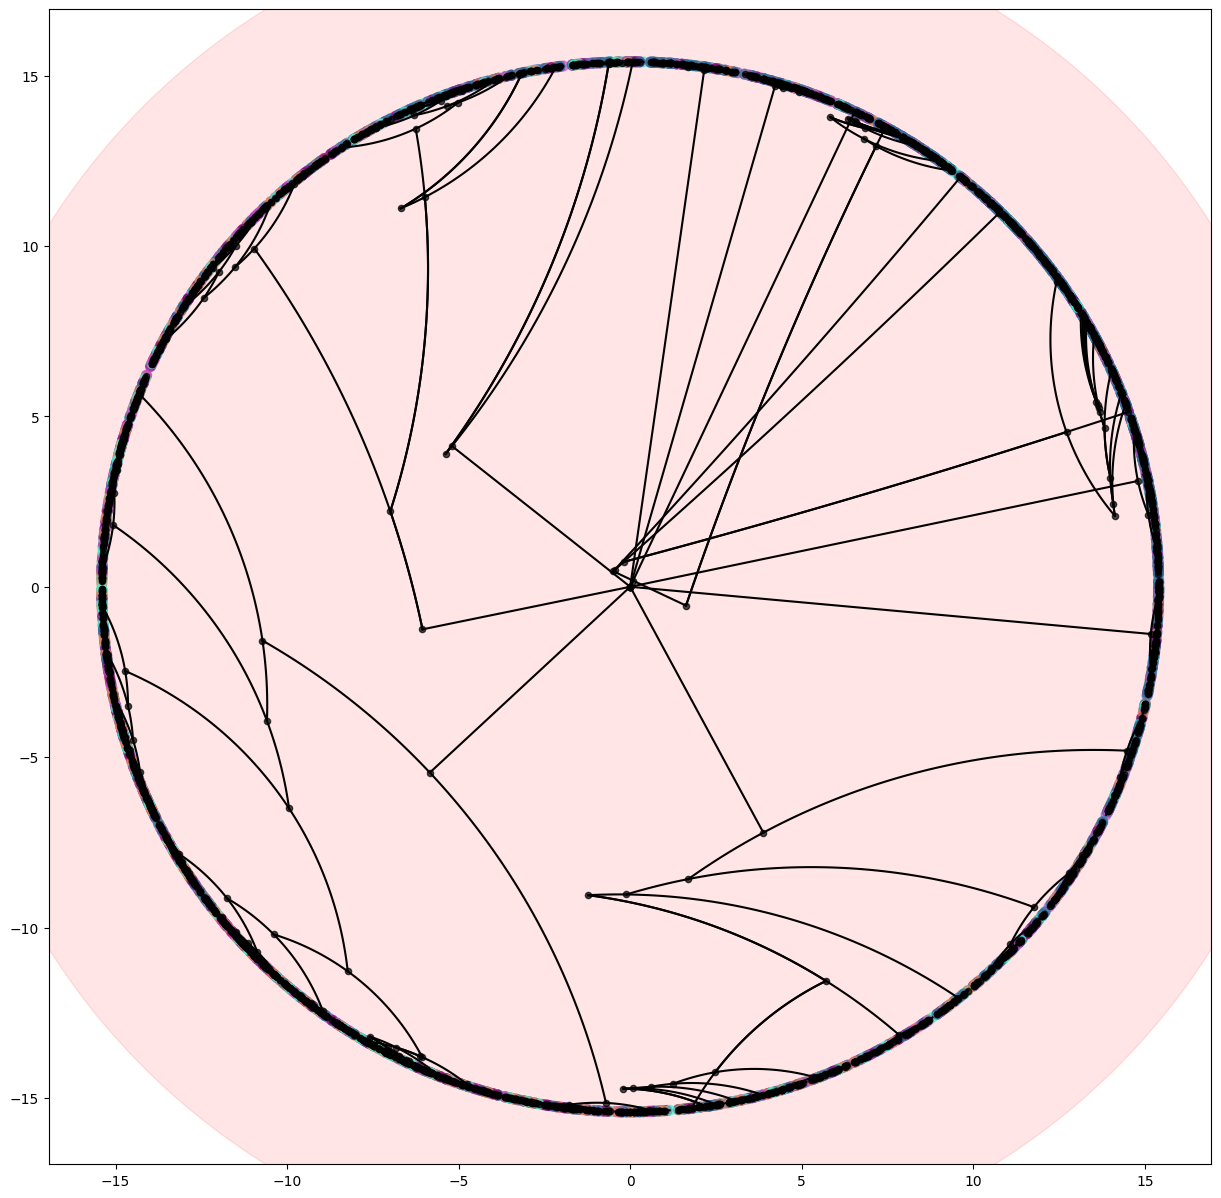

In [125]:
get_Hyper_tree(folder_path+'datas.data',1,adata1.shape[1]+1,0,10,model_path=None,save_path=folder_path,c=-1)


./datas/nolisan/datas.data length:3403
Generating all pairs subset


100%|██████████| 1563/1563 [01:08<00:00, 22.93ex/s, loss=0.908450] 


	 Epoch 0 | average train loss: 1.029491
Optimization finished.


100%|██████████| 1563/1563 [01:08<00:00, 22.94ex/s, loss=0.931499] 


	 Epoch 1 | average train loss: 1.017461
Optimization finished.


100%|██████████| 1563/1563 [01:05<00:00, 23.74ex/s, loss=1.041408] 


	 Epoch 2 | average train loss: 1.005165
Optimization finished.


100%|██████████| 1563/1563 [01:05<00:00, 23.84ex/s, loss=0.958517] 


	 Epoch 3 | average train loss: 0.994736
Optimization finished.


100%|██████████| 1563/1563 [01:06<00:00, 23.55ex/s, loss=1.064849] 


	 Epoch 4 | average train loss: 0.986048
Optimization finished.


100%|██████████| 1563/1563 [01:04<00:00, 24.05ex/s, loss=0.938221] 


	 Epoch 5 | average train loss: 0.979185
Optimization finished.


100%|██████████| 1563/1563 [01:05<00:00, 23.88ex/s, loss=1.016437] 


	 Epoch 6 | average train loss: 0.974052
Optimization finished.


100%|██████████| 1563/1563 [01:05<00:00, 23.71ex/s, loss=0.949868] 


	 Epoch 7 | average train loss: 0.969706
Optimization finished.


100%|██████████| 1563/1563 [01:09<00:00, 22.64ex/s, loss=1.030168] 


	 Epoch 8 | average train loss: 0.966349
Optimization finished.


100%|██████████| 1563/1563 [01:07<00:00, 23.14ex/s, loss=1.067773] 


	 Epoch 9 | average train loss: 0.966276
Optimization finished.


100%|██████████| 1563/1563 [01:08<00:00, 22.96ex/s, loss=0.905500] 


	 Epoch 10 | average train loss: 0.963322
Optimization finished.


100%|██████████| 1563/1563 [01:05<00:00, 23.76ex/s, loss=0.926264] 


	 Epoch 11 | average train loss: 0.960583
Optimization finished.


100%|██████████| 1563/1563 [01:05<00:00, 23.85ex/s, loss=0.991698] 


	 Epoch 12 | average train loss: 0.958601
Optimization finished.


100%|██████████| 1563/1563 [01:05<00:00, 24.00ex/s, loss=0.833729] 


	 Epoch 13 | average train loss: 0.955455
Optimization finished.


100%|██████████| 1563/1563 [01:05<00:00, 23.97ex/s, loss=0.925263] 


	 Epoch 14 | average train loss: 0.953241
Optimization finished.


100%|██████████| 1563/1563 [01:05<00:00, 23.93ex/s, loss=0.946863] 


	 Epoch 15 | average train loss: 0.951124
Optimization finished.


100%|██████████| 1563/1563 [01:05<00:00, 23.76ex/s, loss=0.966425] 


	 Epoch 16 | average train loss: 0.951007
Optimization finished.


100%|██████████| 1563/1563 [01:05<00:00, 23.82ex/s, loss=1.017187] 


	 Epoch 17 | average train loss: 0.951087
Optimization finished.


100%|██████████| 1563/1563 [01:05<00:00, 23.95ex/s, loss=0.873317] 


	 Epoch 18 | average train loss: 0.948984
Optimization finished.


100%|██████████| 1563/1563 [01:06<00:00, 23.67ex/s, loss=0.991151] 


	 Epoch 19 | average train loss: 0.946524
Optimization finished.


100%|██████████| 1563/1563 [01:05<00:00, 23.95ex/s, loss=0.879941] 


	 Epoch 20 | average train loss: 0.944176
Optimization finished.


100%|██████████| 1563/1563 [01:06<00:00, 23.51ex/s, loss=0.886404] 


	 Epoch 21 | average train loss: 0.944380
Optimization finished.


100%|██████████| 1563/1563 [01:05<00:00, 24.01ex/s, loss=1.040550] 


	 Epoch 22 | average train loss: 0.942276
Optimization finished.


100%|██████████| 1563/1563 [01:07<00:00, 23.01ex/s, loss=0.889501] 


	 Epoch 23 | average train loss: 0.942001
Optimization finished.


100%|██████████| 1563/1563 [01:07<00:00, 23.18ex/s, loss=0.908910] 


	 Epoch 24 | average train loss: 0.942112
Optimization finished.


100%|██████████| 1563/1563 [01:07<00:00, 23.18ex/s, loss=0.981003] 


	 Epoch 25 | average train loss: 0.939837
Optimization finished.


100%|██████████| 1563/1563 [01:07<00:00, 23.05ex/s, loss=0.971649] 


	 Epoch 26 | average train loss: 0.939751
Optimization finished.


100%|██████████| 1563/1563 [01:08<00:00, 22.76ex/s, loss=0.884592] 


	 Epoch 27 | average train loss: 0.939840
Optimization finished.


100%|██████████| 1563/1563 [01:06<00:00, 23.38ex/s, loss=1.061596] 


	 Epoch 28 | average train loss: 0.939823
Optimization finished.


100%|██████████| 1563/1563 [01:07<00:00, 23.06ex/s, loss=1.006304] 


	 Epoch 29 | average train loss: 0.937349
Annealing learning rate to: 0.00025
Optimization finished.


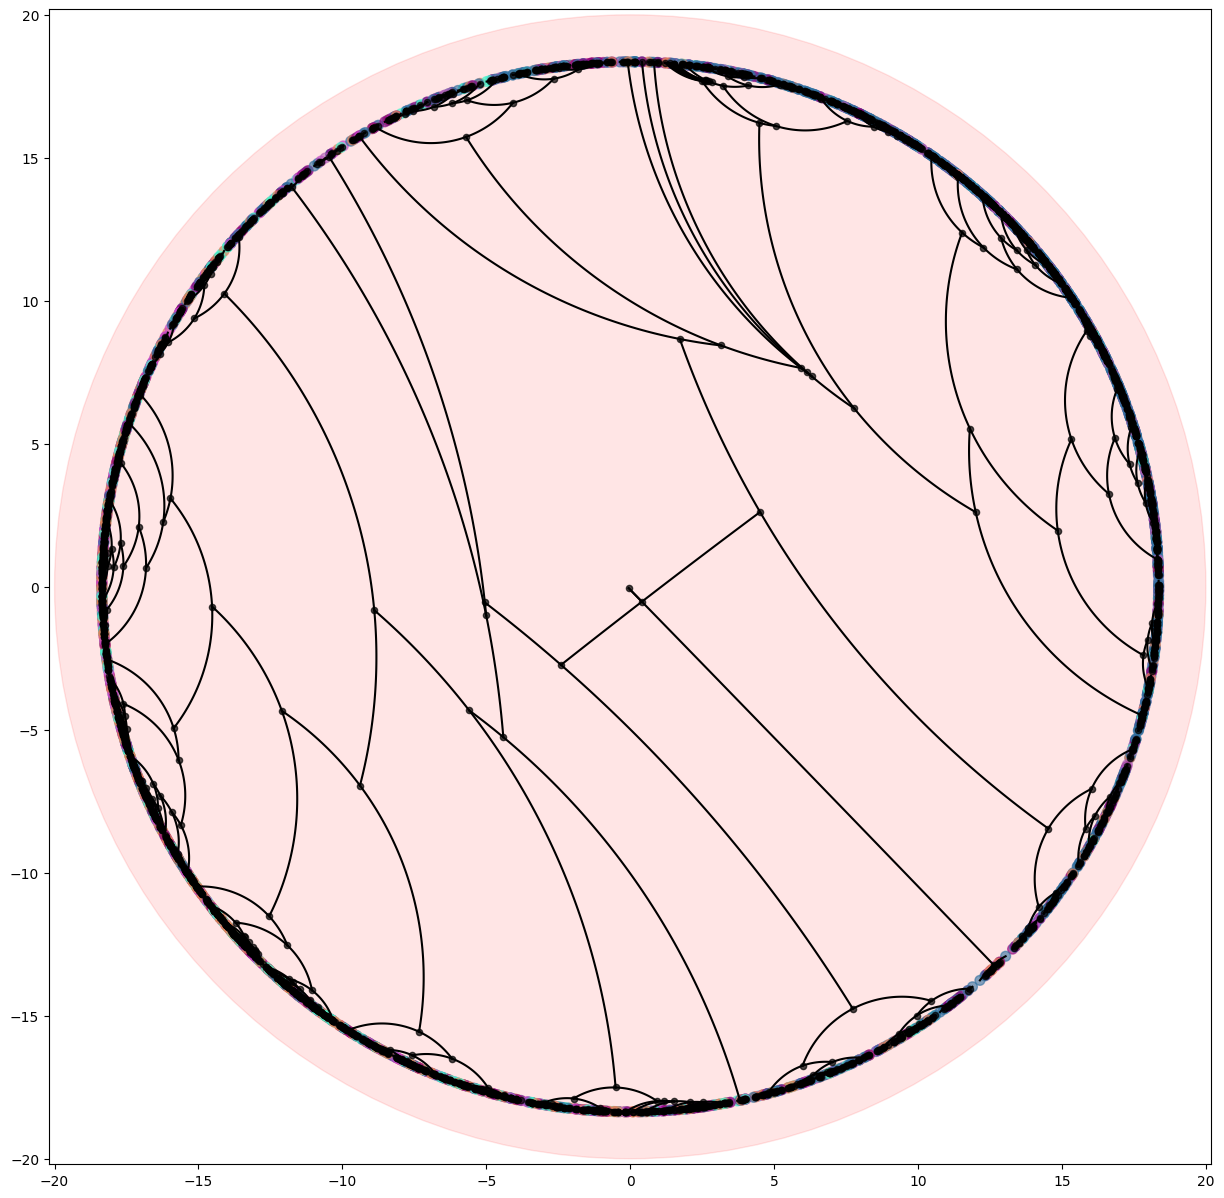

In [126]:
get_Hyper_tree(folder_path+'datas.data',1,adata1.shape[1]+1,0,30,model_path=None,save_path=folder_path,c=-1)


In [127]:
adata1.index = ansss[indexss]
adata1.groupby(adata1.index).mean()

Unnamed: 0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
1,3.143605,-0.745368,1.232226,0.660870,0.586646,0.320761,0.465314,-0.053446,0.309654,-0.342828,0.120751,0.228938,0.316968,0.288948,0.157316,-0.035005,-0.018093,-0.101122,-0.096652,0.084418
2,-0.866332,2.806600,-0.835091,-1.220977,-0.552960,-0.190086,0.024267,0.312850,0.197702,-0.074620,0.069823,0.119049,-0.034900,0.040964,-0.029413,-0.037164,-0.103046,-0.097920,-0.072031,-0.019623
3,-7.484434,-0.210911,-1.344271,1.439222,-0.675245,-0.061747,0.868882,-0.883438,-0.133854,-0.097170,-0.618835,-0.515530,0.572714,0.605506,0.230850,0.183828,0.309990,0.463807,0.091913,-0.131559
4,1.419346,2.680786,1.619777,1.032288,0.945211,0.151090,-0.086599,-0.508933,-0.079033,0.145727,0.001907,-0.259427,-0.643344,-0.189469,-0.248404,-0.121303,-0.045178,0.049021,-0.084698,-0.235123
5,-16.700163,-3.401813,2.680480,-1.098340,1.681926,-0.080610,0.130245,0.065703,-0.262201,-0.388249,0.450525,0.458208,-0.070192,-0.301628,-0.299808,-0.123132,-0.226525,-0.230516,-0.039512,0.064582
6,3.909781,-4.548474,-1.260675,-0.821996,-0.010444,-0.919666,-0.206057,0.129405,-0.518611,-0.074853,0.043720,-0.062521,-0.367906,-0.365652,-0.109610,-0.116132,0.042725,0.132450,0.091783,-0.110018


In [128]:
adata1.groupby(adata1.index).mean().to_csv(folder_path+"datas.data",header=None);
adata1.groupby(adata1.index).mean().to_csv(folder_path+"datas.csv");

./datas/nolisan/datas.data length:6
Generating all pairs superset


  0%|          | 0/1563 [00:00<?, ?ex/s]

100%|██████████| 1563/1563 [01:01<00:00, 25.46ex/s, loss=0.715120] 


	 Epoch 0 | average train loss: 0.774580
Optimization finished.


100%|██████████| 1563/1563 [01:03<00:00, 24.74ex/s, loss=0.725281] 


	 Epoch 1 | average train loss: 0.749143
Optimization finished.


100%|██████████| 1563/1563 [01:02<00:00, 25.11ex/s, loss=0.735931] 


	 Epoch 2 | average train loss: 0.746960
Optimization finished.


100%|██████████| 1563/1563 [01:00<00:00, 25.63ex/s, loss=0.595581] 


	 Epoch 3 | average train loss: 0.747252
Optimization finished.


100%|██████████| 1563/1563 [01:01<00:00, 25.60ex/s, loss=0.892518] 


	 Epoch 4 | average train loss: 0.748518
Optimization finished.


100%|██████████| 1563/1563 [01:01<00:00, 25.57ex/s, loss=0.648022] 


	 Epoch 5 | average train loss: 0.749111
Optimization finished.


100%|██████████| 1563/1563 [01:01<00:00, 25.27ex/s, loss=0.484681] 


	 Epoch 6 | average train loss: 0.743961
Optimization finished.


100%|██████████| 1563/1563 [01:02<00:00, 25.00ex/s, loss=0.637706] 


	 Epoch 7 | average train loss: 0.750223
Optimization finished.


100%|██████████| 1563/1563 [01:02<00:00, 24.89ex/s, loss=0.737902] 


	 Epoch 8 | average train loss: 0.747394
Optimization finished.


100%|██████████| 1563/1563 [01:02<00:00, 24.89ex/s, loss=0.840990] 


	 Epoch 9 | average train loss: 0.743292
Optimization finished.


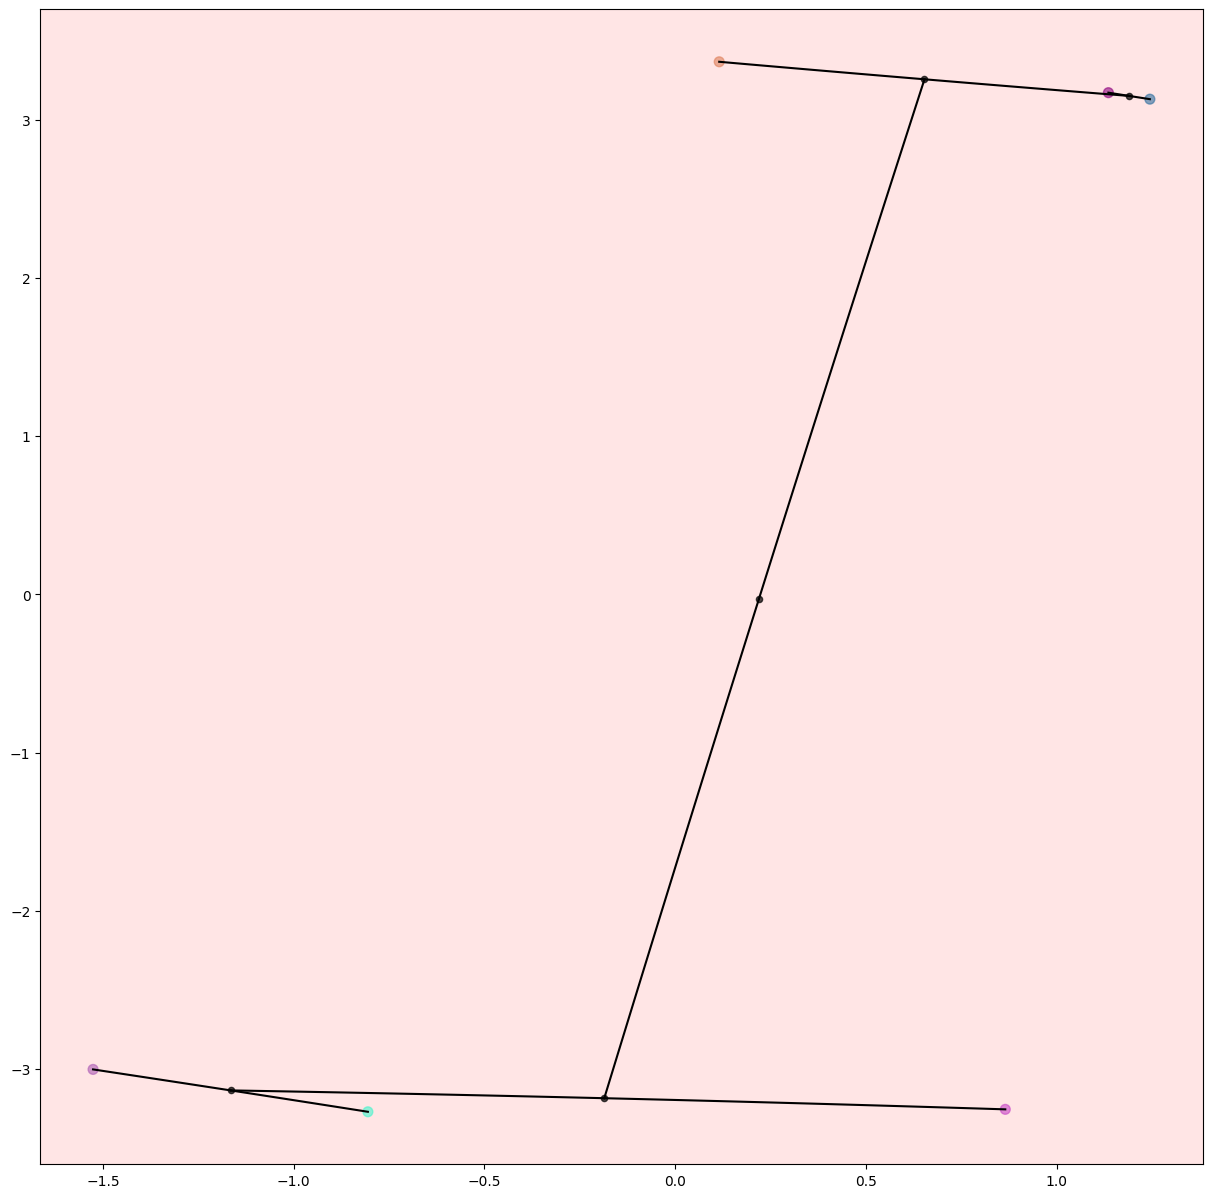

In [129]:
get_Hyper_tree(folder_path+'datas.data',1,adata1.groupby(adata1.index).mean().shape[1]+1,0,10,model_path=None,save_path=folder_path,c=-1)


In [4]:
def search_tree(now,c,merge_list):
    if(len(now.son) != 2):
        return now;
    lson = search_tree(now.son[0],c,merge_list);
    now.son[0] = lson;
    rson = search_tree(now.son[1],c,merge_list);
    now.son[1] = rson

    if(np.linalg.norm(lson.value-rson.value)<=c):
        if(len(lson.son)>1 and len(rson.son)>1):
            pass
        elif(len(lson.son)>1):
            merge_list.append((rson.name,lson.name))
            print(rson.name,lson.name)
            now = rson.copy();
            now.son=[]

            if(len(rson.son)==0):
                now.son.append(lson);
            else:
                now.son.append(lson);
                now.son.append(rson.son);
            # now.son.append(lson);
        else:
            merge_list.append((rson.name,lson.name))
            print(rson.name,lson.name)
            now = lson.copy();
            now.son=[]
            if(len(lson.son)==0):
                now.son.append(rson);
            else:
                now.son.append(lson.son);
                now.son.append(rson);
    return now;

In [19]:
def search_miss_node(now,anslist,smalllist,n):
    if(len(now.son) == 0):
        return now;
    if(len(now.son)==1):
        search_miss_node(now.son[0],anslist,smalllist,n);
        return now;
    lson = search_miss_node(now.son[0],anslist,smalllist,n);
    rson = search_miss_node(now.son[1],anslist,smalllist,n);
    if((int(lson.name)<n and int(rson.name)>n )):
        smalllist.append(int(lson.name))
        anslist.append((lson,rson));
    elif (int(lson.name)>n and int(rson.name)<n ):
        smalllist.append(int(rson.name))
        anslist.append((lson,rson));
    return now
nodes1,n1 = build_hyper_tree(folder_path)
# show_tree(nodes1[0]).show_fig()
anslist = [];
mergelist= []
smalllist = []
search_tree(nodes1[0],1,mergelist)
search_miss_node(nodes1[0],anslist,smalllist,(n1+1)/2)
len(anslist),len(mergelist)
show_tree(nodes1[0]).show_fig()


In [144]:
t=nodes1[0].copy()

AttributeError: 'node' object has no attribute 'copy'

In [142]:
t.son =[]

In [143]:
nodes1[0].son

[]